In [ ]:
import os
import pathlib
import ast
import shutil
from time import time

import pandas as pd
import numpy as np

import librosa
import librosa.display

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
np.random.seed(seed)

In [2]:
# path to the small directory
SMALL_AUDIO_DIR = '/fma_small/fma_small'

# function to get the paths to all the songs in the small dataset
def audio_paths(AUDIO_DIR):
    AUDIO_PATHS = []
    # iterate through all the directories with songs in them
    for path in [os.path.join('/fma_small/fma_small', p) 
                 for p in os.listdir('/fma_small/fma_small') 
                 if not (p.endswith('checksums') or p.endswith('.txt') or p.endswith('.DS_Store'))]:
        # add all songs to the list
        AUDIO_PATHS = AUDIO_PATHS + [os.path.join(path, track).replace('\\', '/') for track in os.listdir(path)]
    
    return AUDIO_PATHS

# store all the small paths
SMALL_PATHS = audio_paths(SMALL_AUDIO_DIR)

In [3]:
# function to load metadata
# adapted from https://github.com/mdeff/fma/blob/master/utils.py
def metadata_load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    pd.CategoricalDtype(categories=SUBSETS, ordered=True))
        except ValueError:
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [4]:
# function to get genre information for each track ID
def track_genre_information(GENRE_PATH, TRACKS_PATH, FILE_PATHS, subset):
    """
    GENRE_PATH (str): path to the csv with the genre metadata
    TRACKS_PATH (str): path to the csv with the track metadata
    FILE_PATHS (list): list of paths to the mp3 files
    subset (str): the subset of the data desired
    """
    # get the genre information
    genres = pd.read_csv(GENRE_PATH)

    # load metadata on all the tracks
    tracks = metadata_load(TRACKS_PATH)

    # focus on the specific subset tracks
    subset_tracks = tracks[tracks['set', 'subset'] <= subset]

    # extract track ID and genre information for each track
    subset_tracks_genre = np.array([np.array(subset_tracks.index), 
                                  np.array(subset_tracks['track', 'genre_top'])]).T
    
    # extract track indices from the file paths
    track_indices = []
    for path in FILE_PATHS:
        track_indices.append(path.split('/')[-1].split('.')[0].lstrip('0'))

    # get the genre associated with each file path, thanks to the path ID
    track_indices = pd.DataFrame({'file_path':FILE_PATHS,'track_id':np.array(track_indices).astype(int)})
    tracks_genre_df = pd.DataFrame({'track_id': subset_tracks_genre[:,0], 'genre': subset_tracks_genre[:,1]})
    track_genre_data = track_indices.merge(tracks_genre_df, how='left')
    
    # label classes with numbers
    encoder = preprocessing.LabelEncoder()
    track_genre_data['genre_nb'] = encoder.fit_transform(track_genre_data.genre)
    
    return track_genre_data

# get genre information for all tracks from the small subset
GENRE_PATH = '/fma_metadata/genres.csv'
TRACKS_PATH = '/fma_metadata/tracks.csv'
subset = 'small'

small_tracks_genre = track_genre_information(GENRE_PATH, TRACKS_PATH, SMALL_PATHS, subset)

In [ ]:
!pip install eyeD3
!pip install python-magic-bin

In [ ]:
audiofile = eyed3.load("/fma_small/fma_small/108/108906.mp3")
print(audiofile.info.time_secs)

In [ ]:
import eyed3

deleted = []

file_paths = small_tracks_genre['file_path'].tolist()
for i in file_paths:
    if eyed3.load(i).info.time_secs < 2:
        deleted.append(i)

In [8]:
def DeleteFiles(myfile):
    # If file exists, delete it.
    if os.path.isfile(myfile):
        os.remove(myfile)
    else:
        # If it fails, inform the user.
        print("Error: %s file not found" % myfile)

In [ ]:
#Deleting corrupt files
for i in deleted:
    DeleteFiles(i)

In [ ]:
#Getting rid of those files from DataFrame
df = small_tracks_genre[small_tracks_genre['file_path'].isin(deleted) == False]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df, df['genre_nb'], test_size=0.20, random_state=1)

In [ ]:
print(f"""
{'-'*40}
# Train samples: {Y_train.shape}
# Test samples: {Y_test.shape}
{'-'*40}
""")

In [ ]:
df_test = X_test.drop_duplicates().reset_index(drop=True)
df_train = X_train.drop_duplicates().reset_index(drop=True)

In [ ]:
def display_waveplot(FILE_PATH):
    y, sr = librosa.load(FILE_PATH)
    
    print('y shape:', np.shape(y))
    print('Sample rate (KHz):', sr)
    print(f'Length of audio: {np.shape(y)[0]/sr}')

    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(y=y, sr=sr);
    plt.title("Sound wave of {}".format(df['file_path'].iloc[0]), fontsize=20)
    plt.show()

In [ ]:
display_waveplot(df['file_path'].iloc[0])

In [11]:
def plot_stft(FILE_PATH):
    x, sampling_rate = librosa.load(FILE_PATH, offset=0, duration=30)
    S = librosa.stft(x)
    
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    fig, ax = plt.subplots(figsize=(15,9))
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='log', sr=sampling_rate,
                             fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='STFT (amplitude to DB scaled) log scale spectrogram')
    #plt.savefig('stft-librosa-log-db.png')

D:\Anaconda\lib\site-packages\librosa\util\decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.

  return f(*args, **kwargs)


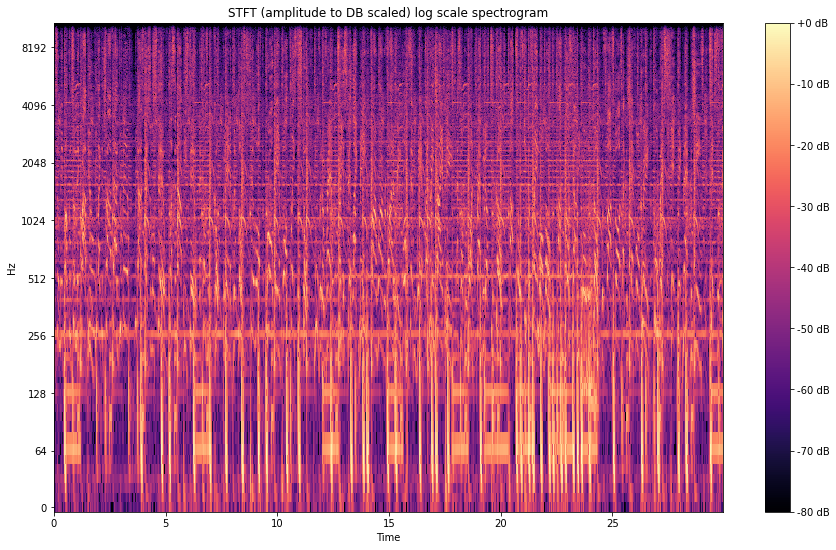

In [12]:
plot_stft(df['file_path'].iloc[0])

Let's create **"train_stft"** folder

In [ ]:
output_path = "/train_stfc"

#if any old file exists in ouput path, it is removed
if os.path.exists(output_path):
    shutil.rmtree(output_path)

#creating folder inside output path
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [ ]:
def create_train_dataset_stft(FILE_PATH, FILE_NAME):
        
    x, sampling_rate = librosa.load(FILE_PATH, offset=0, duration=30)
    S = librosa.stft(x)
    
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(15,9))
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='log', sr=sampling_rate,
                             fmax=8000, ax=ax)
    plt.tight_layout()
    fig.savefig(output_path + '/{}.png'.format(FILE_NAME))
    plt.clf()
    plt.close('all')

In [ ]:
train_paths = df_train['file_path'].tolist()
train_names = df_train['track_id'].tolist()
train_paths, train_names

In [ ]:
!pip install ffmpeg

In [ ]:
#df_deneme.apply(create_train_dataset_stft, args=('track_id',))
#df_train2["X"] = df_train2.apply(lambda x: create_train_dataset_stft(x['file_path'], x['track_id']),axis=1)
for x , y in zip(train_paths, train_names):
    create_train_dataset_stft(x,y)

In [ ]:
import os.path
for x in train_paths:
    if not os.path.exists(x):
        print(x)

In [ ]:
output_path2 = "/test_stfc"

def create_test_dataset_stft(FILE_PATH, FILE_NAME):
        
    x, sampling_rate = librosa.load(FILE_PATH, offset=0, duration=30)
    S = librosa.stft(x)
    
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(15,9))
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='log', sr=sampling_rate,
                             fmax=8000, ax=ax)
    plt.tight_layout()
    fig.savefig(output_path2 + '/{}.png'.format(FILE_NAME))
    plt.clf()
    plt.close('all')

In [ ]:
test_paths = df_test['file_path'].tolist()
test_names = df_test['track_id'].tolist()
test_paths,test_names

In [ ]:
for x , y in zip(test_paths, test_names):
    create_test_dataset_stft(x,y)